Initial model
$$
\begin{aligned}
u' &= \lambda n - \alpha b u + \eta u \\
n' &= \alpha b u + \kappa s - (\beta + \lambda) n \\
s' &= \beta n + \gamma d - (\delta + \kappa) s \\
d' &= \delta s - (\varepsilon + \gamma) d \\
b' &= \varepsilon d + \omega b
\end{aligned}
$$

### Model
#### System of equations

We let $p_i$ with $i \in {1, ..., 5}$ represent the proportions of the population that are uncontacted people ($p_1$), new people ($p_2$), those attending sacrament meeting ($p_3$), those on date to be baptized ($p_4$), and those who are baptized ($p_5$) respectively. 

Each $p_i$ has two rates $\alpha_i(t)$ and $\beta_i(t)$ (these may depend on time) attached to it. $\alpha_i$ is the rate they progress farther towards joining the church, and $\beta_i$ is the rate they regress away from joining the church. Hence, setting $p_0$ and $p_6$ (as well as their respective rates $\alpha_0$, $\beta_0$, $\alpha_6$, and $\beta_6$) equal to 0 for ease of notation, for all $i \in {1, ..., 5}$:

$$
\begin{aligned}
\dot{p}_i &= \alpha_{i-1} p_{i-1} + \beta_{i+1} p_{i+1} - (\alpha_i + \beta_i) p_i
\end{aligned}
$$

We set $\alpha_5 = 0$ since we assume no progression beyond joining the church, we set $\beta_1 = 0$ since we assume no regression beyond being uncontacted, and we also set $\beta_5 = 0$, thus assuming that once a person has joined the church, they do not leave it.

In this model, at the stage of progression $p_i$, $\alpha_{i-1} p_{i-1}$ is the rate at which people progress from the lower stage into stage $p_i$, and $\beta_{i+1} p_{i+1}$ is the rate people regress back to $p_i$ from the next stage along.

The rate at which uncontacted people start being taught is proportional to the number of members, so $\alpha_1(t) = a_1 p_5(t)$ for some constant $a_1$. In this sense, $a_1$ may be thought of as the number of new people being taught per member per unit time. So fix constants $\{a_1, ..., a_5\}$ and $\{b_1, ..., b_5\}$ and define

$$
\alpha_i(t) = \begin{cases} 
a_1 p_5(t), & \text{if } i = 1 \\
a_i, & \text{if } i \in {2, ..., 5} \\
0, & \text{otherwise}
\end{cases}
$$

and

$$\beta_i(t) = b_i$$
for all $t$.

#### One equation

Let $\boldsymbol{p} = \begin{pmatrix} p_1 \\ p_2 \\ p_3 \\ p_4 \\ p_5 \end{pmatrix}$, $\boldsymbol{\alpha} = \begin{pmatrix} \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \alpha_4 \\ \alpha_5 \end{pmatrix} = \begin{pmatrix} a_1 p_5(t) \\ a_2 \\ a_3 \\ a_4 \\ a_5 \end{pmatrix}$, and $\boldsymbol{\beta} = \begin{pmatrix} \beta_1 \\ \beta_2 \\ \beta_3 \\ \beta_4 \\ \beta_5 \end{pmatrix} = \begin{pmatrix} b_1 \\ b_2 \\ b_3 \\ b_4 \\ b_5 \end{pmatrix}$. 

With $\boldsymbol{x} \in \{\boldsymbol{p}, \boldsymbol{\alpha}, \boldsymbol{\beta}\}$, define the following notation for shifting vectors. Let $\boldsymbol{x}_{-} = \begin{pmatrix} x_0 \\ x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix}$ and $\boldsymbol{x}_{+} = \begin{pmatrix} x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \end{pmatrix}$.

Using this notation, we can notate the model with just one equation in the following way:

$$
\dot{\boldsymbol{p}} = \boldsymbol{\alpha}_- \circ \boldsymbol{p}_- + \boldsymbol{\beta}_+ \circ \boldsymbol{p}_+ - (\boldsymbol{\alpha} + \boldsymbol{\beta}) \circ \boldsymbol{p}
$$

where $\circ$ represents elementwise multiplication.


### Stability

We seek to find points of stability for this model.

$$
\dot{\boldsymbol{p}} = \boldsymbol{0} = \boldsymbol{\alpha}_-^T \boldsymbol{p}_- + \boldsymbol{\beta}_+^T \boldsymbol{p}_+ - (\boldsymbol{\alpha} + \boldsymbol{\beta})^T \boldsymbol{p}
$$

It is not immediately apparent that there are any points of stability beyond the trivial $\boldsymbol{p} = \boldsymbol{0}$.

### Simulating the model

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [84]:
def progression(params, p0, ts):
    """
    params: a1, a2, a3, a4, a5, b1, b2, b3, b4, b5 = params
    p0: (p1, ..., p5) at time ts[0]
    ts: time values to evaluate at
    """
    a1, a2, a3, a4, a5, b1, b2, b3, b4, b5 = params
    beta        = np.array([b1, b2, b3, b4, b5])
    beta_plus   = np.array([b2, b3, b4, b5, 0 ])
    
    def p_dot(t, p): # The system defined in "Model" above
        # `p` represents (p1, ..., p5).
        alpha       = np.array([    a1 * p[-1], a2, a3, a4, a5])
        alpha_minus = np.array([0,  a1 * p[-1], a2, a3, a4    ])

        p_minus = np.hstack([[0], p[:-1]])
        p_plus  = np.hstack([p[1:],  [0]])
        return alpha_minus * p_minus + beta_plus * p_plus - (alpha + beta) * p
    
    # Solve the system
    sol = solve_ivp(p_dot, (0, ts[-1]), p0, t_eval=ts)
    return sol.y

In [92]:
labels = ["Uncontacted", "Newly Being Taught", "Attending Sacrament", "On Date", "Baptized"]

def plot_solution(ts, p_sol, population=1, title="Modeled Data"):
    fig, axes = plt.subplots(5, figsize=(4, 6), gridspec_kw={"wspace": 0.5})

    for ax, label, i in zip(axes, labels, range(len(labels))):
        ax.plot(ts / 52, p_sol[i] * population)
        ax.ticklabel_format(style="plain", useOffset=False)
        ax.annotate(
            label,
            xy=(1, 0.5),
            xycoords="axes fraction",
            xytext=(10, 0),
            textcoords="offset points",
            ha="left",
            va="center",
            fontsize=10,
        )  # Adjust text position
        ax.set_xlabel('Years')
        if ax != axes[-1]:  # Check if it's not the bottom subplot
            ax.label_outer()  # Hide x-axis labels and ticks
    plt.suptitle(title)

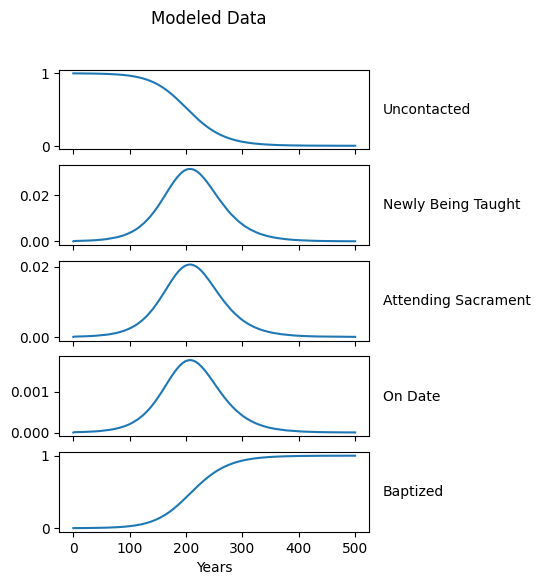

In [93]:
population = 3_000_000
init_p5 = 5 * 4 * 150 / population
init_p1 = 1 - init_p5

params = np.array([
    0.01,        # a1: New people per member each week
    1 / 3,       # a2: Rate going from Being Taught to Attending Sacrament Meeting
    1 / 20,      # a3: Rate going from Attending Sacrament Meeting to On Date
    1 / 12,      # a4: Rate going from On Date to Member
    0,           # a5: Not meaningful in this context, fixed at 0
    0,           # b1: Not meaningful in this context, fixed at 0
    1 / 15,      # b2: Rate going from Being Taught to Uncontacted
    1 / 2,       # b3: Rate going from Attending Sacrament Meeting to Being Taught
    1 / 2,       # b4: Rate going from On Date to Attending Sacrament Meeting
    0            # b5: Rate going from Member to On Date
])

p0 = np.array([
    init_p1,     # Initial proportion of people who are Uncontacted
    0,           # Initial proportion of people who are Being Taught
    0,           # Initial proportion of people who are Attending Sacrament Meeting
    0,           # Initial proportion of people who are On Date
    init_p5      # Initial proportion of people who are Members
])

t_range = np.linspace(0, 52*500, 1000) # 52 weeks

p_sol = progression(params, p0, t_range)

plot_solution(t_range, p_sol)

### Phase portraits

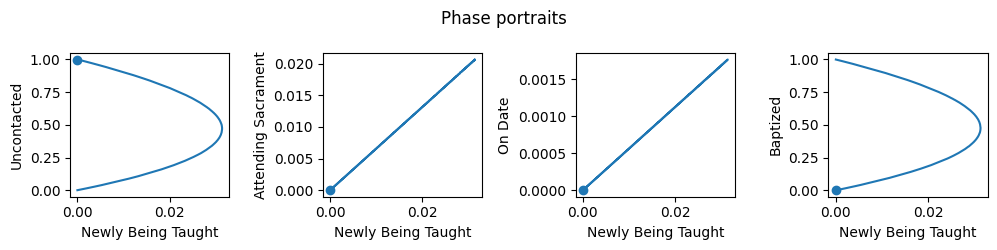

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
# Change this to change which axis is on the bottom
x_index = 1

for i, ax in enumerate(axes):
    if i >= x_index:
        i += 1
    ax.plot(p_sol[x_index], p_sol[i], 'o-', markevery=-1) # Mark the last point
    ax.set_ylabel(labels[i])
    ax.set_xlabel(labels[x_index])
fig.suptitle('Phase portraits')
fig.tight_layout()
plt.show()

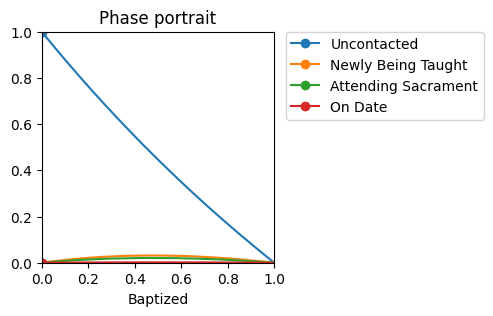

In [127]:
plt.figure(figsize=(3, 3))
# Change this to change which axis is on the bottom
x_index = 4

for i, ax in enumerate(axes):
    if i >= x_index:
        i += 1
    plt.plot(p_sol[x_index], p_sol[i], 'o-', markevery=-1, label=labels[i]) # Mark the last point
plt.xlabel(labels[x_index])
plt.title('Phase portrait')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()